In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
%matplotlib inline

import pandas_datareader as pdr

import requests_cache
session = requests_cache.CachedSession(cache_name='stocks-cache', backend='sqlite')

In [2]:
ts = pdr.DataReader(
    'GC=F',
    start='2000-01-01',
    end='2020-10-10',
    data_source='yahoo',
    session=session
).Close

ts.loc[ts < 1] = None

ts = ts.fillna(method='ffill').rename('GC=F')

ts.index = pd.to_datetime(ts.index)

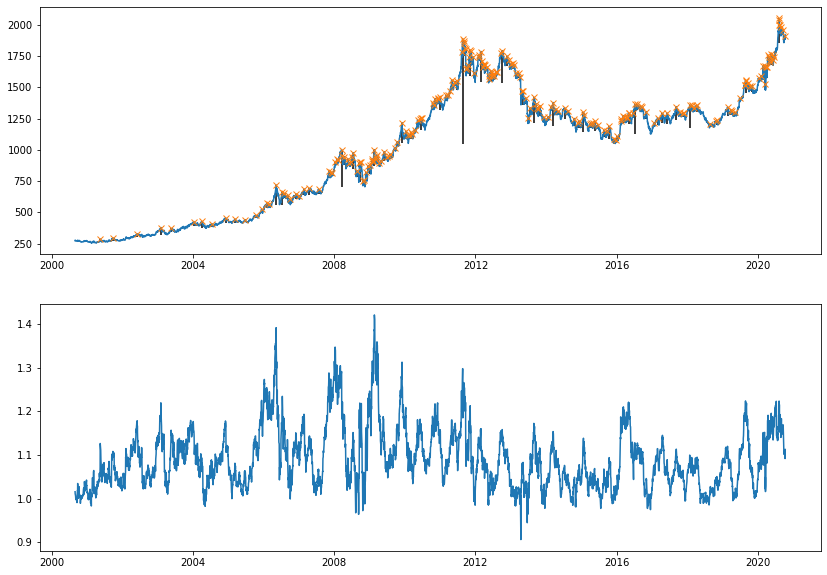

In [8]:
peaks, props = find_peaks(ts, prominence=20)
prominences = props['prominences']
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
ax1.plot(ts.index, ts)
ax1.plot(ts[peaks].index, ts[peaks], 'x')
ax1.vlines(x=ts[peaks].index, ymin=ts[peaks] - prominences, ymax=ts[peaks], colors='black');

gains = ts/ts.shift(1).rolling(90, min_periods=0).min()
ax2.plot(gains.index, gains);

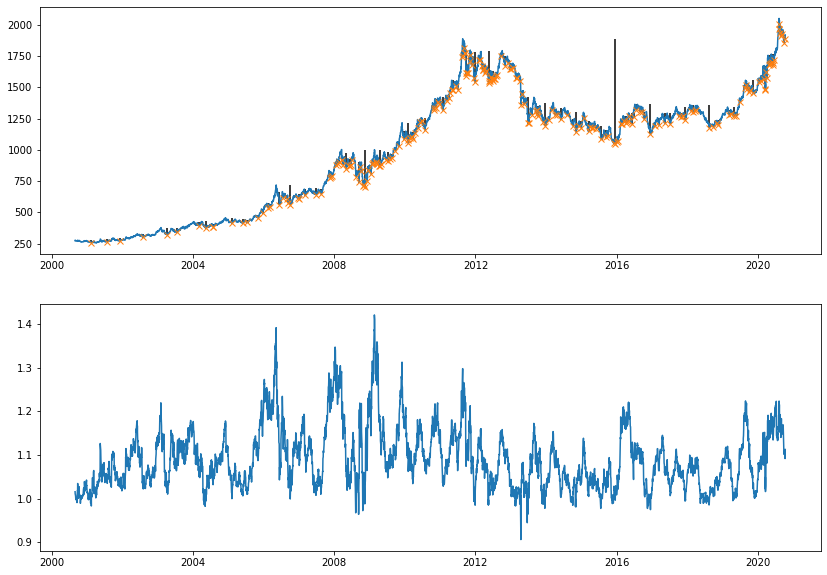

In [12]:
peaks, props = find_peaks(-ts, prominence=20)
prominences = props['prominences']
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
ax1.plot(ts.index, ts)
ax1.plot(ts[peaks].index, ts[peaks], 'x')
ax1.vlines(x=ts[peaks].index, ymin=ts[peaks], ymax=ts[peaks] + prominences, colors='black');

gains = ts/ts.shift(1).rolling(90, min_periods=0).min()
ax2.plot(gains.index, gains);

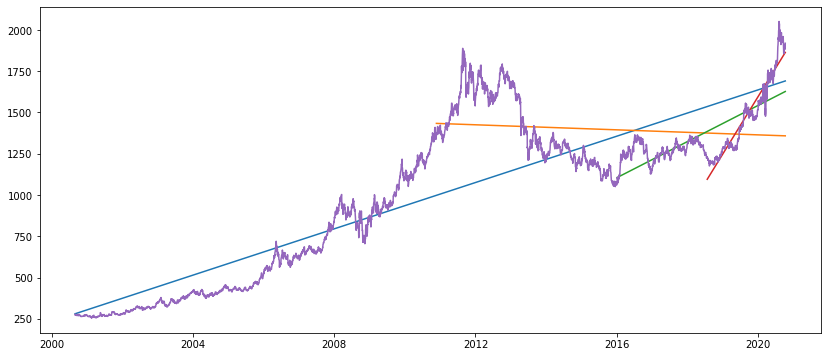

In [15]:
preds = []
for i in range(0, 4):
    tsr = ts[len(ts) - int(len(ts)/2**i):]
    days = (tsr.index - datetime(1970,1,1)).days
    m, b = np.polyfit(days, tsr, 1)
    pred = days*m+b
    preds.append((tsr.index, pred))

plt.figure(figsize=(14, 6))

for idx, pred in preds:
    plt.plot(idx, pred)

plt.plot(ts.index, ts);

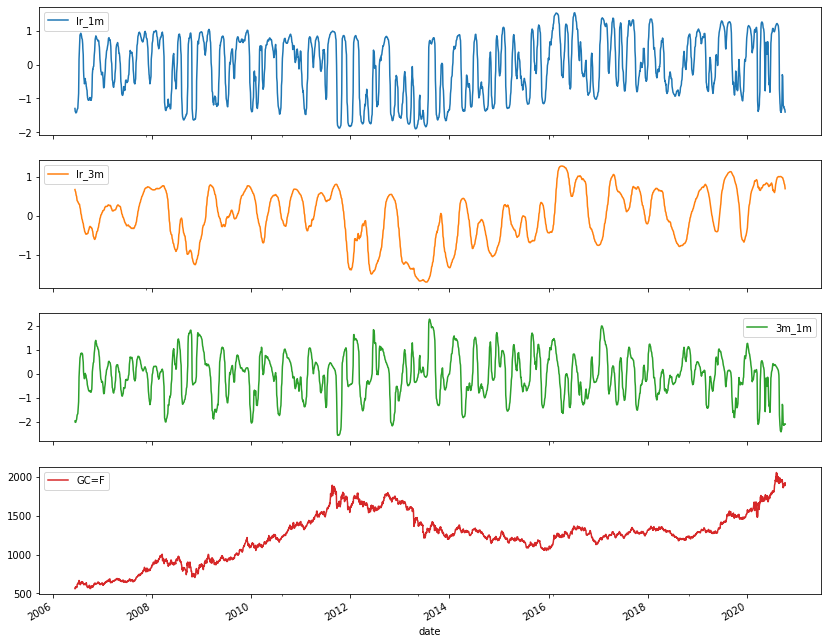

In [6]:
ndays = (ts.index[-1] - ts.index[0]).days
start = ts.index[-1]

def ang(a, b):
    return np.arccos(np.dot(a, b)) * np.sign(np.cross(a, b))

preds = []
for start_day in range(360*4, len(ts), 1):
    dirs = []
    for i in [360*4, 90, 30]:
        tsr = ts[start_day-i:start_day]

        days = (tsr.index - datetime(1970,1,1)).days
        m, b = np.polyfit(days, tsr, 1)
        dir = (days[-1]-days[0], (days[-1]*m+b)-(days[0]*m+b))
        dir_norm = dir / np.linalg.norm(dir)
        dirs.append(dir_norm)
    cd_lr_3m = ang(dirs[0], dirs[1])
    cd_lr_1m = ang(dirs[0], dirs[2])
    cd_3m_1m = ang(dirs[1], dirs[2])

    preds.append([ts.index[start_day], cd_lr_1m, cd_lr_3m, cd_3m_1m])

trend_angles = pd.DataFrame(preds, columns=['date', 'lr_1m', 'lr_3m', '3m_1m']).set_index('date')
trend_angles = trend_angles.join(ts)

trend_angles.plot(figsize=(14, 12), subplots=True);